In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")

print(os.getcwd())

/Users/jh/dev/python/foundation


# Gradient

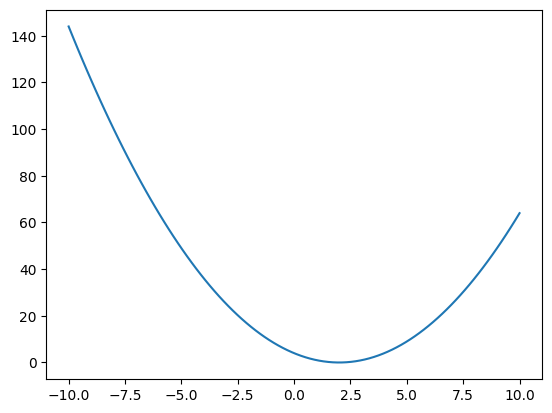

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

xs = np.linspace(-10, 10, 100)

def f(x):
    return (x-2)**2

ys = f(xs)

plt.plot(xs, ys)

In [4]:
def grad(x):
    return 2*(x-2)

print(grad(-5))
print(grad(2))
print(grad(5))

-14
0
6


# Derivatives and Graph

In [5]:
from src.foundation.core import Scalar, Graph
from src.foundation.visualisation import draw_graph

In [6]:
a = Scalar(data=2.0, label="a"); a.grad = 6.0
b = Scalar(data=-3.0, label="b"); b.grad = -4.0
c = Scalar(data=10.0, label="c"); c.grad = -2.0

d = a * b; d.label = "d"; d.grad = -2.0
e = d + c; e.label = "e"; e.grad = -2.0
f = Scalar(data=-2.0, label="f"); f.grad = 4.0
L = e * f; L.label = "L"
L.grad = 1.0

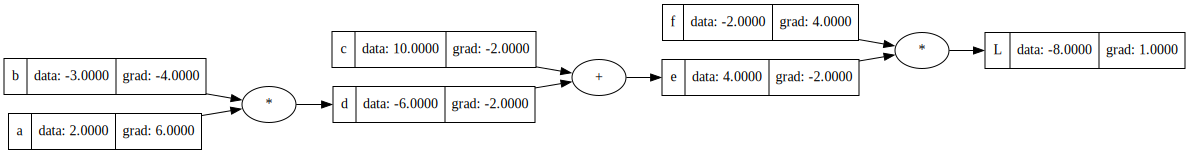

In [7]:
draw_graph(L)

## Derivatives by hand:

d(L)/dL = 1 * L^0 = 1.0

L = e * f = e^1 * f = e * f^1  

d(L)/de = 1 * e^0 * f = f = -2.0  
d(L)/df = e * 1 * f^0 = e = 4.0  

## Backpropagation > Chain rule

e = d + c

#### local derivates:  
d(e)/dd = 1.0  
d(e)/dc = 1.0  

#### chain rule:
d(L)/dd = d(L)/de * d(e)/dd = -2.0 * 1.0 = -2.0  
d(L)/dc = d(L)/de * d(e)/dc = -2.0 * 1.0 = -2.0  


d = a * b

#### local derivates:  
d(d)/da = b = -3.0  
d(d)/db = a = 2.0

#### chain rule:
d(L)/da = d(L)/de * d(e)/dd * d(d)/da = -2.0 * 1.0 * -3.0 = 6.0  
d(L)/db = d(L)/de * d(e)/dd * d(d)/db = -2.0 * 1.0 * 2.0 = -4.0  

## With other words

a.grad = b.data * d.grad  
b.grad = a.data * d.grad  
c.grad = e.grad  
d.grad = e.grad  
e.grad = L.grad * f.data  
f.grad = L.grad * e.data  
L.grad = 1.0  

from back to front:

=> (+) just distributes the gradient across nodes
=> (*) takes data of the other node and multiplies it with the gradient to get its gradient

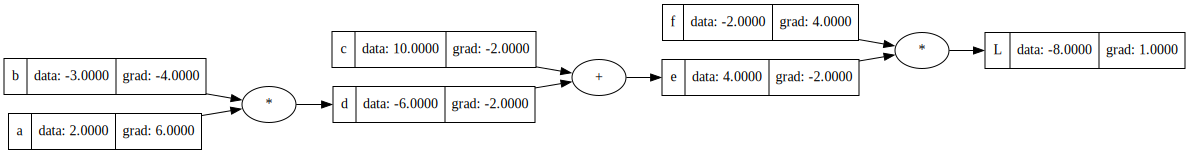

In [8]:
draw_graph(L)

In [9]:
# forward pass

step_size = 0.01

a.data += step_size * a.grad
b.data += step_size * b.grad
c.data += step_size * c.grad
f.data += step_size * f.grad

d = a * b
e = c + d
L = e * f

L.data

-7.286496

## Neuron

In [10]:
# input values
x1 = Scalar(2.0, label="x1")
x2 = Scalar(0.0, label="x2")

# weights
w1 = Scalar(-3.0, label="w1")
w2 = Scalar(1.0, label="w2")

# bias
bias = Scalar(6.8813735870195432, label="b")

# weighted inputs
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

# neuron
neuron = x1w1x2w2 + bias; neuron.label = "n"

#output
output = neuron.tanh(); output.label = "o"

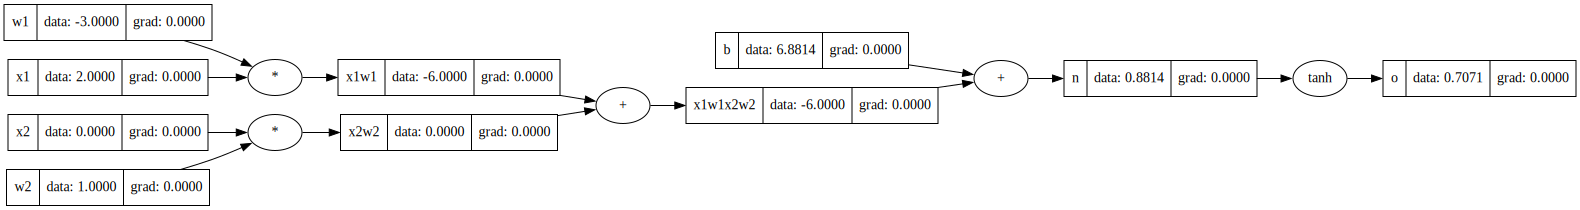

In [11]:
draw_graph(output)

### Automated backward propagation

In [12]:
output.backward()

### Semi automated backward progapagation

In [13]:
output.grad = 1.0

In [14]:
output._backward()

In [15]:
neuron._backward()

In [16]:
bias._backward()

In [17]:
x1w1x2w2._backward()

In [18]:
x2w2._backward()

In [19]:
x1w1._backward()

### Manuall backward propogation

In [20]:
import math

output.grad = 1.0

neuron.grad = 1 - math.tanh(neuron.data)**2 * output.grad # 0.5 => chain rule + derivative of tanh(x) according to wikipedia

bias.grad = neuron.grad # 0.5
x1w1x2w2.grad = neuron.grad # 0.5

x1w1.grad = x1w1x2w2.grad # 0.5
x2w2.grad = x1w1x2w2.grad # 0.5

x1.grad = w1.data * x1w1.grad # -1.5
w1.grad = x1.data * x1w1.grad # 1.0

x2.grad = w2.data * x2w2.grad # 0.5
w2.grad = x2.data * x2w2.grad # 0.0

## Derivatives

o = tanh(n)  
d(o)/dn = 1 - o^2 = 0.5 # wikipedia  


## Redesign tanh

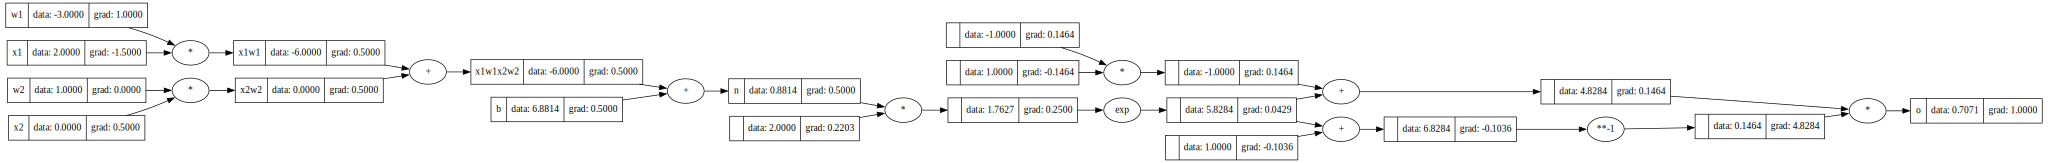

In [21]:
# input values
x1 = Scalar(2.0, label="x1")
x2 = Scalar(0.0, label="x2")

# weights
w1 = Scalar(-3.0, label="w1")
w2 = Scalar(1.0, label="w2")

# bias
bias = Scalar(6.8813735870195432, label="b")

# weighted inputs
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

# neuron
neuron = x1w1x2w2 + bias; neuron.label = "n"

#output
# output = neuron.tanh()
exp = (2 * neuron).exp()
output = (exp - 1)/(exp + 1)

output.label = "o"
output.backward()
draw_graph(output)

## PyTorch comparison

In [22]:
import torch

In [23]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

bias = torch.Tensor([6.8813735870195432]).double(); bias.requires_grad = True

x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1x2w2 = x1w1 + x2w2

neuron = x1w1x2w2 + bias

output = torch.tanh(neuron)

print(f"output data: {output.data.item()}")
output.backward()

print("--- gradients ---")
print(f"w1 data: {w1.data.item()} | grad: {w1.grad.item()}")
print(f"x1 data: {x1.data.item()} | grad: {x1.grad.item()}")
print(f"w2 data: {w2.data.item()} | grad: {w2.grad.item()}")
print(f"x2 data: {x2.data.item()} | grad: {x2.grad.item()}")

output data: 0.7071066904050358
--- gradients ---
w1 data: -3.0 | grad: 1.0000002567688737
x1 data: 2.0 | grad: -1.5000003851533106
w2 data: 1.0 | grad: 0.0
x2 data: 0.0 | grad: 0.5000001283844369


# MLP - Multi layer perceptron

In [24]:
from src.foundation.nn import MLP

In [25]:
x = [2.0, 3.0, -1.0]
mlp = MLP(no_inputs=3, no_layer_outputs=[4, 4, 1])
out = mlp(x)
print(out)

[Scalar(data=-0.799326766449015)]


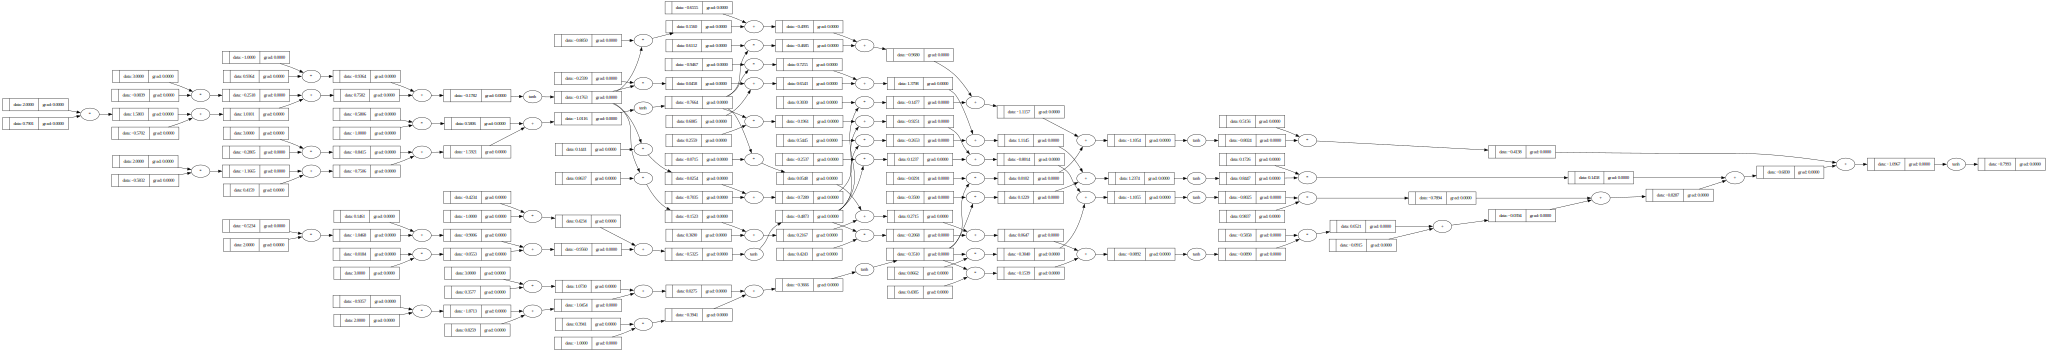

In [26]:
draw_graph(out[0])

# Training

## Simplest - single layer, single neuron perceptron

In [27]:
simple_model = MLP(no_inputs=1, no_layer_outputs=[1])

In [28]:
x = [2.0]
y = 1.0

prediction = simple_model(x)[0]
prediction

Scalar(data=-0.936637740307548)

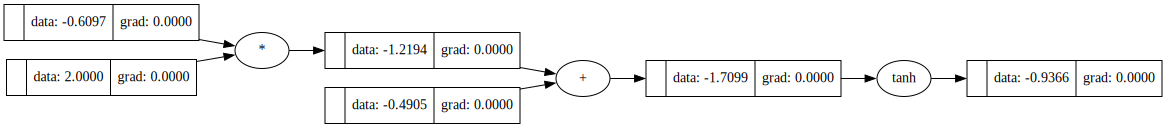

In [29]:
draw_graph(prediction)

In [30]:
# mse
loss = (prediction - y) ** 2
loss

Scalar(data=3.7505657371835253)

In [31]:
loss.backward()

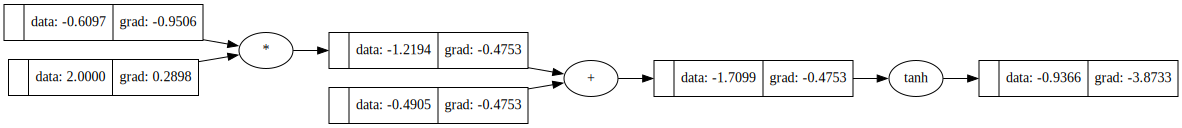

In [32]:
draw_graph(prediction)

weight (data=0.4823) was randomly initialiazed  
gradient (grad=-0.1147) was backpropagated through loss (mse)

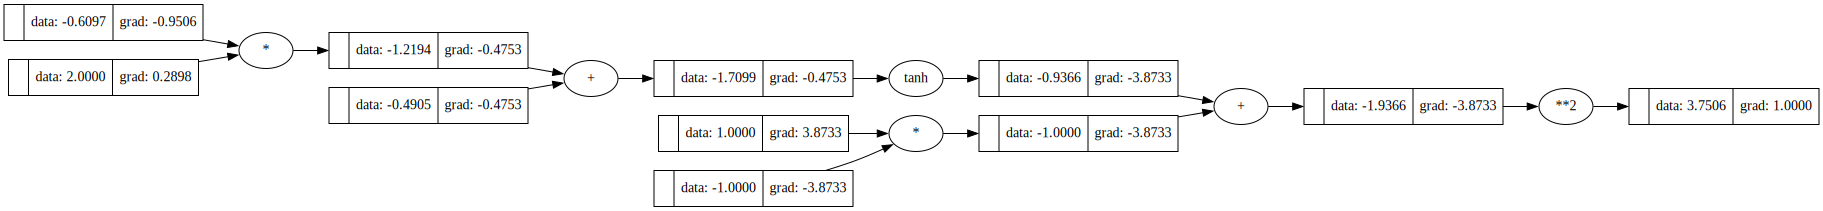

In [33]:
draw_graph(loss)

In [34]:
simple_model.layers[0].neurons[0].w[0].grad

-0.9505772809321408

gradient is negative => influence on loss is negative.  

increasing the weight of this neuron would make the loss go down.

## MLP

In [35]:
# input
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# labels aka desired targets
ys = [1.0, -1.0, -1.0, 1.0]

model = MLP(no_inputs=3, no_layer_outputs=[4, 4, 1])

In [36]:
# forward pass
y_preds = [model(x) for x in xs]
y_preds

[[Scalar(data=0.7120026949067583)],
 [Scalar(data=0.5186566219592235)],
 [Scalar(data=0.8941991895078908)],
 [Scalar(data=0.5777439743916186)]]

In [37]:
# mse loss
losses = [(y_pred[0] - y)**2 for y_pred, y in zip(y_preds, ys)]
losses

[Scalar(data=0.08294244774096976),
 Scalar(data=2.3063179354205996),
 Scalar(data=3.5879905695323497),
 Scalar(data=0.17830015116258602)]

In [38]:
loss = sum(losses)
loss

Scalar(data=6.072608656115535)

In [39]:
# backward pass
loss.backward()

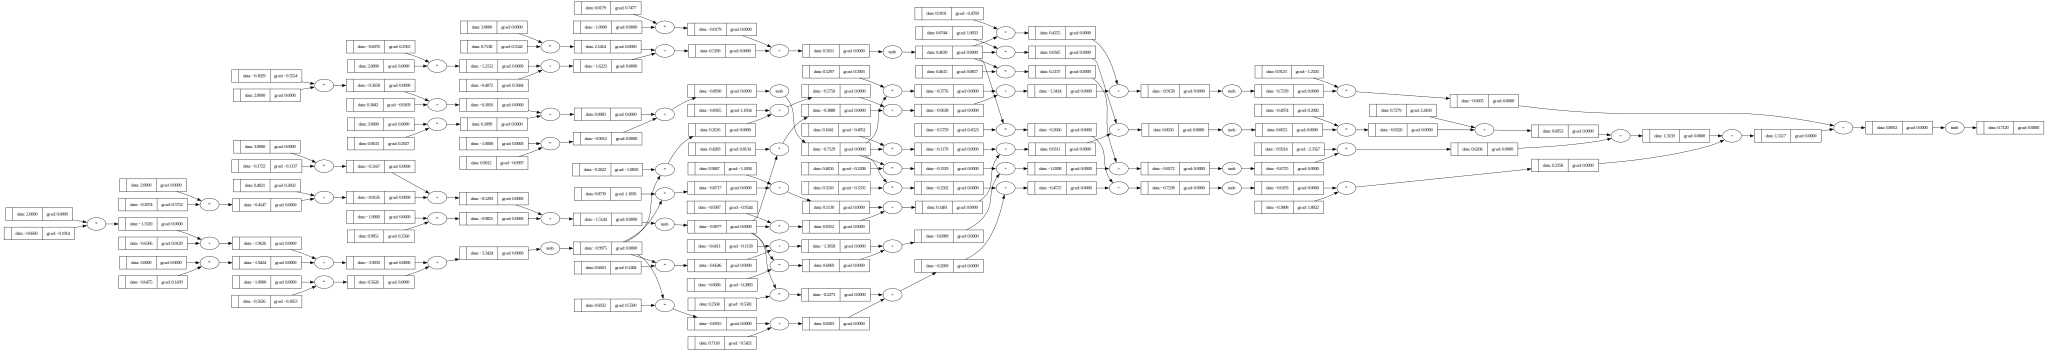

In [40]:
draw_graph(y_preds[0][0])

In [41]:
model.layers[0].neurons[0].w[0].grad

-0.10142539573229939

In [42]:
model.layers[0].neurons[0].w[0].data

-0.665978020417398

In [43]:
# update
step_size = 0.01

for param in model.parameters():
    param.data += -1 * step_size * param.grad  # modify the gradient by a small step size in the direction of the gradient

the direction of the gradient points in the direction which increases the loss => we want to decreate the loss => go in the opposite direction of the gradient => multiply by -1

In [44]:
model.layers[0].neurons[0].w[0].data

-0.6649637664600749

### Full training loop - Gradient descent

In [45]:
# input
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# labels aka desired targets
ys = [1.0, -1.0, -1.0, 1.0]

model = MLP(no_inputs=3, no_layer_outputs=[4, 4, 1])
model.summary()

===== Model Summary =====
1. Dense Layer of 4 Tanh-Neurons: 16 params
2. Dense Layer of 4 Tanh-Neurons: 20 params
3. Dense Layer of 1 Tanh-Neurons: 5 params
Total trainable parameters: 41


In [46]:
no_epochs = 100
step_size = 0.01


for i in range(no_epochs):

    # forward pass
    y_preds = [model(x) for x in xs]
    
    # zero grad
    for param in model.parameters():
        param.grad = 0.0
    
    # mse loss
    losses = [(y_pred[0] - y)**2 for y_pred, y in zip(y_preds, ys)]
    loss = sum(losses)
    print(f"iteration {i} loss: {loss.data}")

    # backward pass
    loss.backward()
    
    # update of weights and biases
    for param in model.parameters():
        param.data += -1 * step_size * param.grad  # modify the gradient by a small step size in the direction of the gradient

iteration 0 loss: 2.7676851189283913
iteration 1 loss: 2.753471885202714
iteration 2 loss: 2.7410811091470766
iteration 3 loss: 2.7301997166241603
iteration 4 loss: 2.7205436750071765
iteration 5 loss: 2.7118661285219177
iteration 6 loss: 2.7039595786618076
iteration 7 loss: 2.696654053045818
iteration 8 loss: 2.689812990420265
iteration 9 loss: 2.683328156023909
iteration 10 loss: 2.677114464424549
iteration 11 loss: 2.6711052182662662
iteration 12 loss: 2.665248001765776
iteration 13 loss: 2.65950129247541
iteration 14 loss: 2.6538317539912635
iteration 15 loss: 2.648212123479597
iteration 16 loss: 2.6426195918749187
iteration 17 loss: 2.63703457710891
iteration 18 loss: 2.6314398022299668
iteration 19 loss: 2.6258196049495544
iteration 20 loss: 2.620159419782331
iteration 21 loss: 2.6144453869792645
iteration 22 loss: 2.608664053323894
iteration 23 loss: 2.60280213854462
iteration 24 loss: 2.596846347819379
iteration 25 loss: 2.5907832159341186
iteration 26 loss: 2.584598972430836
i

In [47]:
model.parameters()

[Scalar(data=0.21103785036541714),
 Scalar(data=0.17685851306845451),
 Scalar(data=0.9639456993034061),
 Scalar(data=-0.02815874609302036),
 Scalar(data=-0.7399883667690035),
 Scalar(data=0.4967449976373241),
 Scalar(data=0.013408375062315804),
 Scalar(data=1.0340355033784234),
 Scalar(data=-0.3878973827334168),
 Scalar(data=-1.140448557855459),
 Scalar(data=-0.4572768598106869),
 Scalar(data=-0.7631313159611851),
 Scalar(data=-1.0539118488727717),
 Scalar(data=-0.9007238517767787),
 Scalar(data=-0.3165992432704469),
 Scalar(data=0.2231084868561209),
 Scalar(data=-0.7685498826366449),
 Scalar(data=0.09358973109658247),
 Scalar(data=-0.43719490442702547),
 Scalar(data=-0.21331287629470136),
 Scalar(data=-0.6296818414167852),
 Scalar(data=-0.7334984828349178),
 Scalar(data=0.3098917485343413),
 Scalar(data=-0.9842199411456095),
 Scalar(data=0.1259004689024294),
 Scalar(data=-0.8194822204913467),
 Scalar(data=0.8903541048791692),
 Scalar(data=0.8394140291374045),
 Scalar(data=0.3786434691

In [48]:
# trained model predictions
[model(x) for x in xs]

[[Scalar(data=0.2847207634272169)],
 [Scalar(data=-0.8315210408544359)],
 [Scalar(data=-0.6122167260826897)],
 [Scalar(data=0.5795064917669553)]]

### Fit method

In [49]:
# input
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# labels aka desired targets
ys = [1.0, -1.0, -1.0, 1.0]

model = MLP(no_inputs=3, no_layer_outputs=[4, 4, 1])
model.summary()

===== Model Summary =====
1. Dense Layer of 4 Tanh-Neurons: 16 params
2. Dense Layer of 4 Tanh-Neurons: 20 params
3. Dense Layer of 1 Tanh-Neurons: 5 params
Total trainable parameters: 41


In [50]:
history = model.fit(x=xs, y=ys, lr=0.05, epochs=100)

epoch 0 loss: 3.191483544651161
epoch 1 loss: 1.8068862560516141
epoch 2 loss: 1.1361701732390266
epoch 3 loss: 0.7768869070849085
epoch 4 loss: 0.5619126259661724
epoch 5 loss: 0.42618937922005873
epoch 6 loss: 0.3361489798856008
epoch 7 loss: 0.2736333222200681
epoch 8 loss: 0.22846582830462364
epoch 9 loss: 0.19470690615328895
epoch 10 loss: 0.1687418449299833
epoch 11 loss: 0.14828190334431576
epoch 12 loss: 0.13182480837205082
epoch 13 loss: 0.11835237032660473
epoch 14 loss: 0.10715463795102836
epoch 15 loss: 0.09772402351573828
epoch 16 loss: 0.08968948494760404
epoch 17 loss: 0.08277440228573515
epoch 18 loss: 0.07676889950308773
epoch 19 loss: 0.0715112200077665
epoch 20 loss: 0.06687492156354596
epoch 21 loss: 0.06275989876076979
epoch 22 loss: 0.059085976298000664
epoch 23 loss: 0.05578826237070536
epoch 24 loss: 0.052813728436916396
epoch 25 loss: 0.050118657337598196
epoch 26 loss: 0.04766671543726988
epoch 27 loss: 0.045427479363619155
epoch 28 loss: 0.04337529812850474
e

In [51]:
preds = [model(x) for x in xs]
preds

[[Scalar(data=0.9333863415699105)],
 [Scalar(data=-0.9550286553799475)],
 [Scalar(data=-0.9436754740353943)],
 [Scalar(data=0.9360862785494173)]]

In [52]:
history

{'epochs': {0: {'loss': 3.191483544651161},
  1: {'loss': 1.8068862560516141},
  2: {'loss': 1.1361701732390266},
  3: {'loss': 0.7768869070849085},
  4: {'loss': 0.5619126259661724},
  5: {'loss': 0.42618937922005873},
  6: {'loss': 0.3361489798856008},
  7: {'loss': 0.2736333222200681},
  8: {'loss': 0.22846582830462364},
  9: {'loss': 0.19470690615328895},
  10: {'loss': 0.1687418449299833},
  11: {'loss': 0.14828190334431576},
  12: {'loss': 0.13182480837205082},
  13: {'loss': 0.11835237032660473},
  14: {'loss': 0.10715463795102836},
  15: {'loss': 0.09772402351573828},
  16: {'loss': 0.08968948494760404},
  17: {'loss': 0.08277440228573515},
  18: {'loss': 0.07676889950308773},
  19: {'loss': 0.0715112200077665},
  20: {'loss': 0.06687492156354596},
  21: {'loss': 0.06275989876076979},
  22: {'loss': 0.059085976298000664},
  23: {'loss': 0.05578826237070536},
  24: {'loss': 0.052813728436916396},
  25: {'loss': 0.050118657337598196},
  26: {'loss': 0.04766671543726988},
  27: {'